In [2]:
import torch
import torch.nn as nn
import glob
import os
import sys
import numpy as np 
import random
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from torch.utils.tensorboard import SummaryWriter

In [3]:
def get_images(paths, labels, nb_samples=None, shuffle=True):

    if nb_samples is not None:
        sampler = lambda x: random.sample(x, nb_samples)
    else:
        sampler = lambda x: x
    
    labels_images = [(i, os.path.join(path, image)) for i, path in zip(labels, paths) for image in sampler(os.listdir(path))]
    
    if shuffle is None:
        random.shuffle(labels_images)
    
    return labels_images


In [4]:
torch.cuda.is_available()

False

In [5]:
get_images(['omniglot_resized/Angelic/character01', 'omniglot_resized/Angelic/character02','omniglot_resized/Angelic/character03'], np.identity(3), nb_samples=5)

[(array([1., 0., 0.]), 'omniglot_resized/Angelic/character01/0965_19.png'),
 (array([1., 0., 0.]), 'omniglot_resized/Angelic/character01/0965_03.png'),
 (array([1., 0., 0.]), 'omniglot_resized/Angelic/character01/0965_18.png'),
 (array([1., 0., 0.]), 'omniglot_resized/Angelic/character01/0965_04.png'),
 (array([1., 0., 0.]), 'omniglot_resized/Angelic/character01/0965_09.png'),
 (array([0., 1., 0.]), 'omniglot_resized/Angelic/character02/0966_15.png'),
 (array([0., 1., 0.]), 'omniglot_resized/Angelic/character02/0966_16.png'),
 (array([0., 1., 0.]), 'omniglot_resized/Angelic/character02/0966_18.png'),
 (array([0., 1., 0.]), 'omniglot_resized/Angelic/character02/0966_02.png'),
 (array([0., 1., 0.]), 'omniglot_resized/Angelic/character02/0966_04.png'),
 (array([0., 0., 1.]), 'omniglot_resized/Angelic/character03/0967_05.png'),
 (array([0., 0., 1.]), 'omniglot_resized/Angelic/character03/0967_09.png'),
 (array([0., 0., 1.]), 'omniglot_resized/Angelic/character03/0967_10.png'),
 (array([0.,

In [6]:
def image_file_to_array(filename, dim_input):

    image = np.asarray(plt.imread(filename))
    plt.imshow(1-image, cmap='gray', )
    image = np.reshape(image, [dim_input])
    image = 1. - image.astype(np.float32) / 255.
    

    return image

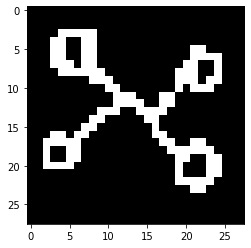

In [7]:
im = image_file_to_array("omniglot_resized/Angelic/character01/0965_01.png", 784)

In [8]:
type(im)

numpy.ndarray

In [9]:
class DataGenerator(object):

    def __init__(self, num_classes, num_samples_per_class, config={}):

        self.num_classes = num_classes
        self.num_samples_per_class = num_samples_per_class
        
        data_folder = config.get('data_folder', './omniglot_resized')

        self.image_size = config.get('image_size', (28, 28))
        self.input_dim = np.prod(self.image_size)
        self.output_dim = self.num_classes

        character_folder = [os.path.join(data_folder, alphabet, character)
                            for alphabet in os.listdir(data_folder)
                            for character in os.listdir(os.path.join(data_folder, alphabet))]
        
        random.seed(1)
        random.shuffle(character_folder)

        meta_train = 1100 
        meta_val = 100

        self.meta_train_characters = character_folder[: meta_train]
        self.meta_val_characters = character_folder[meta_train: meta_train+meta_val]
        self.meta_test_characters = character_folder[meta_train+meta_val: ]

    def sample_batch(self, batch_type, batch_size):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """

        if batch_type == "train":
            folders = self.meta_train_characters
        if batch_type == "test":
            folders = self.meta_test_characters
        if batch_type == "val":
            folders = self.meta_val_characters

        num_batches = len(folders)//batch_size
        folders = folders[:num_batches*batch_size]
        all_image_batches = []
        all_label_batches = []

        for batch_idx in range(batch_size):
            sample_classes =  random.sample(folders, self.num_classes)
            #sample_classes = folders[batch_idx*self.num_classes : (batch_idx+1)*self.num_classes]
            one_hot_labels = np.identity(self.num_classes)

            labels_images = get_images(sample_classes, one_hot_labels, nb_samples=self.num_samples_per_class, shuffle=False)
            train_images = []
            train_labels = []    
            for sample_idx, (labels, images) in enumerate(labels_images):
                train_images.append(image_file_to_array(images, 784))
                train_labels.append(labels)

            
            train_images, train_labels = shuffle(train_images, train_labels)

            labels = np.vstack(train_labels).reshape((-1, self.num_classes, self.num_classes))  # K, N, N
            images = np.vstack(train_images).reshape((self.num_samples_per_class, self.num_classes, -1))  # K x N x 784

            all_label_batches.append(labels)
            all_image_batches.append(images)

        all_image_batches = np.stack(all_image_batches).astype(np.float32)
        all_label_batches = np.stack(all_label_batches).astype(np.float32)

        return all_label_batches, all_image_batches      


In [10]:
N = 5
K = 2
B = 4

def plot_images(imgs, labels, n_col=N, title=None):
    plt.figure(figsize=(8, K+1))
    n_row = np.ceil(len(imgs) / n_col).astype(int)
    for img_idx, (img, label) in enumerate(zip(imgs, labels)):
        plt.subplot(n_row, n_col, img_idx+1)
        plt.imshow(img, cmap='gray')
        #plt.axis('off')
        plt.title(label.argmax())

    if title:
        plt.suptitle(title)
    plt.show()

(4, 3, 5, 784)

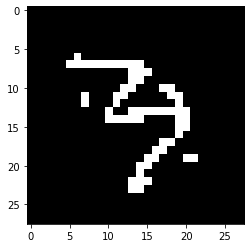

In [11]:
ordered_generator = DataGenerator(N, K+1)
batch_labels, batch_imgs = ordered_generator.sample_batch('train', B)

batch_imgs.shape

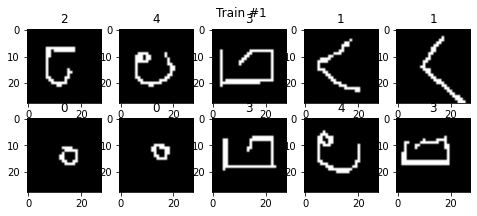

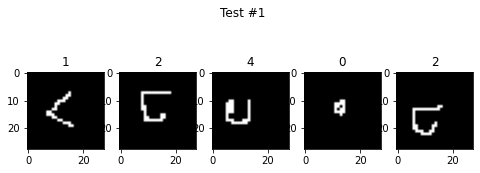

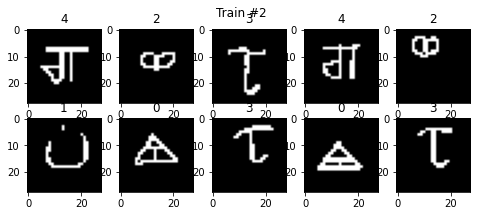

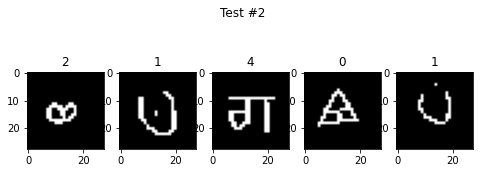

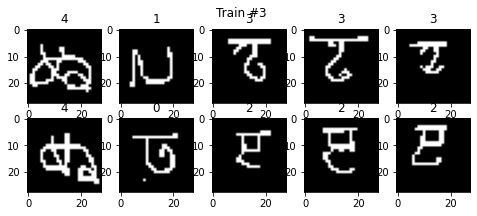

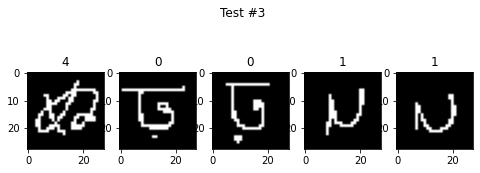

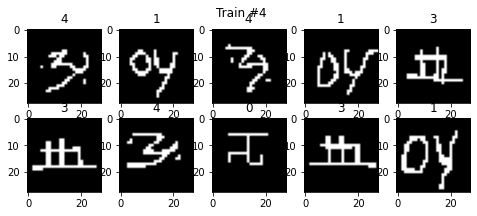

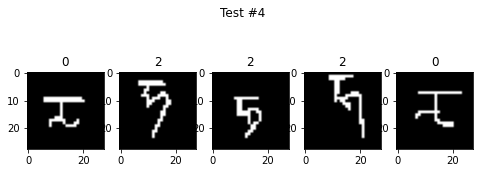

In [12]:
for i in range(B):
    images, labels = batch_imgs[i], batch_labels[i]
    train_images, train_labels = images[:-1].reshape(-1, 28, 28), labels[:-1].reshape(-1, N)  # K-1, N, N
    test_images, test_labels = images[-1:].reshape(-1, 28, 28), labels[-1:].reshape(-1, N) # 1, N, N

    plot_images(train_images, train_labels, n_col=N, title=f'Train #{i+1}')
    plot_images(test_images, test_labels, n_col=N, title=f'Test #{i+1}')

In [13]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
    

In [14]:
class MANN(nn.Module):

    def __init__(self, num_classes, num_samples, embed_size=784):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.num_samples = num_samples
        self.embed_size = embed_size
        self.lstm1 = nn.LSTM(embed_size+num_classes, 128) #Pytorch always has return_sequences=True
        self.lstm2 = nn.LSTM(128, num_classes)

    def forward(self, inputs):
        x, _ = self.lstm1(inputs)
        x, _ = self.lstm2(x)
        last_n_step_logits = x[-self.num_classes:].transpose(0,1).reshape(-1, self.num_classes)
        return last_n_step_logits

        

In [15]:
torch.cuda.is_available()

False

In [16]:
N = 5
K = 3
B = 128
D = 784

In [17]:
def evaluate(model, data_generator, step, optimizer, criterion, device):
    
    model.eval()
    with torch.no_grad():
        print("*" * 5 + "Iter " + str(step) + "*" * 5)
        batch_labels, batch_imgs = data_generator.sample_batch('test', B)
        inputs, targets = prep_data(batch_imgs, batch_labels, device)
        test_set_logits = model(inputs)
        pred = test_set_logits.argmax(axis=1)
        
        test_loss = criterion(test_set_logits, targets)
        test_accuracy = (1.0 * (pred==targets)).mean().item()
        
        return test_loss, test_accuracy
        
        

In [18]:
def prep_data(batch_imgs, batch_labels, device):
    
    B, K, N, D = batch_imgs.shape
    batch_imgs = batch_imgs.reshape(B, -1, D)
    test_labels = batch_labels[:, -1:]
    train_labels = np.concatenate((batch_labels[:, :-1], np.zeros_like(test_labels)), axis=1).reshape((B, -1, N))
    inputs = torch.tensor(np.dstack((batch_imgs, train_labels))).transpose(0,1).to(device)
    targets = torch.tensor(test_labels.squeeze(1).reshape((-1, N)).argmax(axis=1)).to(device)

    return inputs, targets

    

In [19]:
def train(model, data_generator, optimizer, criterion, device, save=True):
    
    exp_name = f"_Exp_N={N}_K={K}_B={B}"
    writer = SummaryWriter(comment=exp_name)
    
    n_step = 20000
   
    loss_val = []
    test_accs = []
    for step in range(n_step):
        model.train()
        batch_labels, batch_imgs = data_generator.sample_batch('train', B)
        inputs, targets = prep_data(batch_imgs, batch_labels, device)
        test_set_logits = model(inputs)
        
        optimizer.zero_grad()
        loss = criterion(test_set_logits, targets)
        loss.backward()
        print(loss)
        
        writer.add_scalar("Loss/Train", loss, step)
        
        if step%50 == 0:
            test_loss, test_accuracy = evaluate(model, data_generator, step, optimizer, criterion, device)
            print("Train Loss:", loss.item(), "Test Loss:", test_loss.item())
            print("Test Accuracy", test_accuracy)
            test_accs.append(test_accuracy)
            writer.add_scalar("Loss/Test", test_loss, step)
            writer.add_scalar("Accuracy/Test", test_accuracy, step)
            
        optimizer.step()
    
    plt.plot(range(len(test_accs)), test_accs)
    plt.xlabel("Step (x 50)")
    plt.ylabel("Test accuracy")
    plt.savefig(f"models/train_{exp_name}.png")
    if save:
        torch.save(model.state_dict(), f"models/model_{exp_name}")
    return model
    

In [ ]:
model = MANN(N, K+1).to(device)
data_generator = DataGenerator(N, K+1)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

train(model, data_generator, optimizer, criterion, device)

tensor(1.6940, grad_fn=<NllLossBackward>)
*****Iter 0*****
Train Loss: 1.6939951181411743 Test Loss: 1.7035259008407593
Test Accuracy 0.20624999701976776
tensor(1.6619, grad_fn=<NllLossBackward>)
tensor(1.6225, grad_fn=<NllLossBackward>)
tensor(1.6162, grad_fn=<NllLossBackward>)
tensor(1.6136, grad_fn=<NllLossBackward>)
tensor(1.6171, grad_fn=<NllLossBackward>)
tensor(1.6132, grad_fn=<NllLossBackward>)
tensor(1.6116, grad_fn=<NllLossBackward>)
tensor(1.6201, grad_fn=<NllLossBackward>)
tensor(1.6150, grad_fn=<NllLossBackward>)
tensor(1.6144, grad_fn=<NllLossBackward>)
tensor(1.6072, grad_fn=<NllLossBackward>)
tensor(1.6127, grad_fn=<NllLossBackward>)
tensor(1.6090, grad_fn=<NllLossBackward>)
tensor(1.6112, grad_fn=<NllLossBackward>)
tensor(1.6105, grad_fn=<NllLossBackward>)
tensor(1.6104, grad_fn=<NllLossBackward>)
tensor(1.6139, grad_fn=<NllLossBackward>)
tensor(1.6114, grad_fn=<NllLossBackward>)
tensor(1.6089, grad_fn=<NllLossBackward>)
tensor(1.6089, grad_fn=<NllLossBackward>)
tensor

KeyboardInterrupt: 